# New Template
jupyter nbconvert --to html --TemplateExporter.exclude_input=True --output-dir="T:/Temp/" NEW_TEMPLATE.ipynb

# Setup
Specify some paths and names in the cell below.

In [1]:
configDir = "T:/Data/"  # Path to folder where you saved your wildlifeconfig file.
filter_set_json = None
taxon_json = None
query_name = 'withRTest3'
use_eBird = True
use_GBIF = False

### GBIF request method
Whether to get records from GBIF in a darwin core archive.  "False" uses the GBIF API, which has limitations that may be important.  "True" requests results be emailed in a darwin core archive.

In [2]:
get_dwca = True 

### An important, temporary bug fix
There is a bug with mpl_toolkits, the following code is a temporary fix until they resolve the bug.
https://stackoverflow.com/questions/52911232/basemap-library-using-anaconda-jupyter-notebooks-keyerror-proj-lib/54087410#54087410

os.environ['PROJ_LIB'] should be set equal to something like "c:/Users/jramone/AppData/Local/Continuum/miniconda3/envs/wrangler/Library/share"

In [3]:
#import os
#os.environ['PROJ_LIB'] = "c:/Users/nmtarr/AppData/Local/Continuum/miniconda3/envs/wrangler/Library/share"

Nothing to fill out in the next cell

In [4]:
%matplotlib inline
import sqlite3
import pprint
import json
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_rows', 150)
from IPython.display import Image
from pygbif import occurrences
import matplotlib.pyplot as plt
import os
from datetime import datetime
t1 = datetime.now()
import sys
sys.path.append(configDir)
import wranglerconfig as config
codeDir = config.codeDir
sys.path.append(codeDir)
import wrangler_functions as functions
working_directory = config.workDir
output_database = working_directory + query_name + '.sqlite'
username = config.gbif_username
password = config.gbif_password
email = config.gbif_email
EBD_file = config.EBD_file
print("Notebook run " + str(t1))
print(output_database)

Notebook run 2021-04-05 19:51:57.075490
T:/Occurrence_Records/withRTest3.sqlite


# Specify a taxon
GBIF and eBird Basic Dataset can currently be accessed.  Specificy the appropriate identifiers in the cell below.

NOTE -- cautions about taxon concept mismatches and errors

In [5]:
your_taxon_id = "TestCuckoo"
gbif_id = 2496287 
ebird_id = "Yellow-billed Cuckoo"
detection_distance_m = 200
taxon_polygon = "POLYGON ((-84.09680233298448 36.69265225442667, -84.07962135716329 34.5561660300382, -84.07962135716329 34.5561660300382, -80.25685423694925 34.65515526072436, -81.15026497965096 36.71331438415306, -84.09680233298448 36.69265225442667))"

In [6]:
# If a json was provided, use it, otherwise create a new one with info that was provided.
if taxon_json is None:
    # Build a species dictionary
    taxon_info = {"ID": your_taxon_id, "GBIF_ID": gbif_id, "EBIRD_ID": ebird_id, "detection_distance_m": detection_distance_m,
                  "TAXON_EOO": taxon_polygon}

    # Save as json object
    out_file = open(working_directory + your_taxon_id + ".json", "w")  
    json.dump(taxon_info, out_file) 
    out_file.close() 

if taxon_json is not None:
    with open(taxon_json, "r") as f:
        taxon_info = json.load(f)
        f.close()
        
pprint.pprint(taxon_info)

{'EBIRD_ID': 'Yellow-billed Cuckoo',
 'GBIF_ID': 2496287,
 'ID': 'TestCuckoo',
 'TAXON_EOO': 'POLYGON ((-84.09680233298448 36.69265225442667, '
              '-84.07962135716329 34.5561660300382, -84.07962135716329 '
              '34.5561660300382, -80.25685423694925 34.65515526072436, '
              '-81.15026497965096 36.71331438415306, -84.09680233298448 '
              '36.69265225442667))',
 'detection_distance_m': 200}


# Specify a filter set
Fill out this section to specify how you want records filtered and cleaned.  Alternatively, you can load a filter set here by specifying a path in the first cell of this notebook.  

To skip a filter, enter "None" without the quotation marks or "".  

In [7]:
filter_set_name = "test_filters_1"

### Date limits
Enter year and month ranges.  For example, years_range = 2015,2017 and months_range = 3,6

Justification: 

In [8]:
years_range = "2015,2016"
months_range = "5,6"

### Country
Notes:

In [9]:
country = "US"

### Bounding box
Coordinates should correspond to WGS84 (EPSG:4326).  Don't use this option if you specify a query polygon below.

Notes:

In [10]:
lat_range = "27,41"
lon_range = "-89,-75"

### Taxon EOO
True or False whether you want to apply the taxon EOO to the filtering.  If True, removes records with centroids outside of the extent of occurrence geometry you provided in taxon_info.

Notes:

In [11]:
use_taxon_geometry = True

### Geoissue
Are GBIF records with noted geoissues OK to include? GBIF only.

Notes:

In [12]:
geoissue = False

### Collections
List collection codes that you'd like to omit. GBIF only.

Notes:

In [13]:
collection_codes_omit = ""

### Institutions
List institution codes that you'd like to omit. GBIF only

Notes:

In [14]:
institutions_omit = ""

### Datasets
List datasets that you'd like to omit.
#### ebird project here?

Notes:

In [15]:
datasets_omit = ""

### Coordinate uncertainty
Do you want to remove records without coordinate uncertainty (1) or leave them in the data set (0)?  Note that eBird records in GBIF (EOD) do not have this and neither do data in the EBD dataset.  With the EBD, the length of traveling counts is used as a surrogate value /??!!!!!?????.  

max_coordinate_uncertainty must be an integer greater than 0.

default_coordUncertainty -- coordinateUncertaintyInMeters is often not provided.  Here is an option to use a default.  If you don't want anything entered, set this equal to False (boolean, not string).

A maximum for coordinate uncertainty can also be set in meters.

Notes:

In [16]:
has_coordinate_uncertainty = True
default_coordUncertainty = 1000
max_coordinate_uncertainty = 10000

### Bases
List bases of records that you want to omit.  GBIF only.

Notes:

In [17]:
bases_omit = ""

### Sampling protocols
List sampling protocols that you would like to omit.  Options for eBird are ........._______

Notes:

In [18]:
sampling_protocols_omit = ""

### Issues
List issues that you want to omit.  GBIF only.

Notes:

In [19]:
issues_omit = ""

### Geometry (polygons)
Specify polygons to use for spatial filtering.  Records with coordinates outside of the polygons will be removed.  You can specify a geometry for the query and one for the species.  The species geometry is included to facilitate better handling of taxonomic issues.  If both are provided, the intersection is calculated and used as the filter.  The format should be well known text in WGS84 (EPSG 4326), and very importantly, vertices need to be listed counter-clockwise.  See the ccw_wkt_from_shp() function in wrangler functions for help.

Notes:

In [20]:
query_polygon = "POLYGON ((-82.74809573102132 36.96082629937069, -85.0932989306133 35.63154639485496, -81.0987220521874 33.56697226279766, -79.4235769096217 36.34054727735634, -79.4235769096217 36.34054727735634, -82.74809573102132 36.96082629937069))"

### Duplicates
Specify whether duplicates on latitude, longitude, and date should be included.

Notes:

In [21]:
duplicates_OK = False

### Save or load the filter set

In [29]:
if filter_set_json is None:
    # Build a filter set dictionary
    filter_set = {"name": filter_set_name, "query_polygon": query_polygon, "issues_omit": issues_omit,
                  "sampling_protocols_omit": sampling_protocols_omit, "bases_omit": bases_omit,
                  "has_coordinate_uncertainty": has_coordinate_uncertainty, "geoissue": geoissue,
                  "default_coordUncertainty": default_coordUncertainty,
                  "max_coordinate_uncertainty": max_coordinate_uncertainty,
                  "datasets_omit": datasets_omit, "collection_codes_omit": collection_codes_omit,
                  "institutions_omit": institutions_omit, "geoissue": geoissue, "use_taxon_geometry": use_taxon_geometry,
                  "lat_range": lat_range, "lon_range": lon_range, "country": country, 
                  "years_range": years_range, "months_range": months_range, "duplicates_OK": duplicates_OK, "get_dwca": get_dwca}
    
    # Replace empty strings with None
    for x in filter_set.keys():
        if filter_set[x] == "":
            filter_set[x] = None
    
    # Save as json object
    with open(working_directory + filter_set_name + ".json", "w") as f:
        json.dump(filter_set, f) 
        f.close()
        
if filter_set_json is not None:
    with open(filter_set_json, "r") as f:
        filter_set = json.load(f)
        f.close()
        
    # Replace empty strings with None
    for x in filter_set.keys():
        if filter_set[x] == "":
            filter_set[x] = None
        
pprint.pprint(filter_set)

{'bases_omit': None,
 'collection_codes_omit': None,
 'country': 'US',
 'datasets_omit': None,
 'default_coordUncertainty': 1000,
 'duplicates_OK': False,
 'geoissue': False,
 'get_dwca': True,
 'has_coordinate_uncertainty': True,
 'institutions_omit': None,
 'issues_omit': None,
 'lat_range': '27,41',
 'lon_range': '-89,-75',
 'max_coordinate_uncertainty': 10000,
 'months_range': '5,6',
 'name': 'test_filters_1',
 'query_polygon': 'POLYGON ((-82.74809573102132 36.96082629937069, '
                  '-85.0932989306133 35.63154639485496, -81.0987220521874 '
                  '33.56697226279766, -79.4235769096217 36.34054727735634, '
                  '-79.4235769096217 36.34054727735634, -82.74809573102132 '
                  '36.96082629937069))',
 'sampling_protocols_omit': None,
 'use_taxon_geometry': True,
 'years_range': '2015,2016'}


### Connect to output database, record species and filter information.

In [23]:
output_db_conn= sqlite3.connect(output_database)
cursor = output_db_conn.cursor()
pd.DataFrame(taxon_info.values(), taxon_info.keys()).applymap(str).to_sql(name='taxon_concept', con=output_db_conn, if_exists='replace')
pd.DataFrame(filter_set.values(), filter_set.keys()).applymap(str).to_sql(name='filter_set', con=output_db_conn, if_exists='replace')
output_db_conn.close()

## Run Processes

In [24]:
# Create an output database
functions.build_output_database(output_database)

In [25]:
# Run the appropriate queries
if use_eBird == True and use_GBIF == True:
    # Run eBird query
    ebird_data = functions.get_EBD_records(taxon_info, filter_set, working_directory, EBD_file, query_name)
    
    # Omit Cornell Lab of Ornithology records when querying GBIF
    #  collectionCode like "EBIRD*" should be omited.  HOW???>>>>>>>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    '''
    filter_set2 = filter_set
    filter_set2["collection_codes_omit"] = filter_set["collection_codes_omit"]''' 
    gbif_data = functions.get_GBIF_records(taxon_info, filter_set, query_name, working_directory, username, password, email) 

elif use_eBird == True and use_GBIF == False:
    # Run eBird query
    ebird_data = functions.get_EBD_records(taxon_info, filter_set, working_directory, EBD_file, query_name)
    gbif_data = None

elif use_eBird == False and use_GBIF == True:
    # Run GBIF query
    gbif_data = functions.get_GBIF_records(taxon_info, filter_set, query_name, working_directory, username, password, email)
    ebird_data = None

Summarized fields returned: 0:00:00.015624
Index(['eBird_sp_code', 'global_unique_identifier', 'checklist_id', 'project_code', 'last_edited_date', 'common_name', 'observation_count', 'locality', 'latitude', 'longitude', 'observation_date', 'observer_id', 'effort_distance_km', 'protocol_type', 'effort_area_ha', 'trip_comments', 'species_comments', 'effort_distance_m', 'coordinateUncertaintyInMeters', 'geometry'], dtype='object')
GBIF_download_doi                 float64
accessRights                      float64
basisOfRecord                     float64
bibliographicCitation             float64
collectionCode                     object
coordinateUncertaintyInMeters     float64
dataGeneralizations               float64
datasetName                       float64
decimalLatitude                   float64
decimalLongitude                  float64
detection_distance_m              float64
ebird_id                           object
establishmentMeans                float64
eventDate             

In [26]:
ebird_data.head()
ebird_data.to_csv("T:/Temp/ebird.csv")
print(ebird_data.columns)

Index(['GBIF_download_doi', 'accessRights', 'basisOfRecord', 'bibliographicCitation', 'collectionCode', 'coordinateUncertaintyInMeters', 'dataGeneralizations', 'datasetName', 'decimalLatitude', 'decimalLongitude', 'detection_distance_m', 'ebird_id', 'establishmentMeans', 'eventDate', 'eventRemarks', 'filter_set_name', 'footprintSRS', 'footprintWKT', 'gbif_id', 'general_remarks', 'georeferenceProtocol', 'georeferenceRemarks', 'georeferenceVerificationStatus', 'georeferencedBy', 'habitat', 'identificationQualifier', 'identifiedBy', 'identifiedRemarks', 'individualCount', 'informationWitheld',
       'institutionID', 'issues', 'license', 'locality', 'locationAccordingTo', 'locationRemarks', 'modified', 'occurrenceRemarks', 'occurrenceStatus', 'radius_m', 'record_id', 'recordedBy', 'retrieval_date', 'samplingProtocol', 'scientificName', 'source', 'taxonConceptID', 'taxon_info_name', 'verbatimLocality', 'weight', 'weight_notes'],
      dtype='object')


In [30]:
pprint.pprint(filter_set)

{'bases_omit': None,
 'collection_codes_omit': None,
 'country': 'US',
 'datasets_omit': None,
 'default_coordUncertainty': 1000,
 'duplicates_OK': False,
 'geoissue': False,
 'get_dwca': True,
 'has_coordinate_uncertainty': True,
 'institutions_omit': None,
 'issues_omit': None,
 'lat_range': '27,41',
 'lon_range': '-89,-75',
 'max_coordinate_uncertainty': 10000,
 'months_range': '5,6',
 'name': 'test_filters_1',
 'query_polygon': 'POLYGON ((-82.74809573102132 36.96082629937069, '
                  '-85.0932989306133 35.63154639485496, -81.0987220521874 '
                  '33.56697226279766, -79.4235769096217 36.34054727735634, '
                  '-79.4235769096217 36.34054727735634, -82.74809573102132 '
                  '36.96082629937069))',
 'sampling_protocols_omit': None,
 'use_taxon_geometry': True,
 'years_range': '2015,2016'}


In [31]:
# Filter out records with undesirable values, locations, and/or duplication.
import importlib
importlib.reload(functions)
functions.apply_filters(ebird_data=ebird_data, gbif_data=None, filter_set=filter_set, 
                        taxon_info=taxon_info, working_directory=working_directory, 
                        query_name=query_name)

Summarized values acquired: 0:00:00.062482
Performed filtering: 0:00:00
88 duplicate records dropped: 0:00:00.559974


### How many records made it through the filters?
This is the number of species occurrence records that were actually saved in the occurrence record sqlite database.

In [34]:
output_db_conn= sqlite3.connect(output_database)
cursor = output_db_conn.cursor()
record_count = cursor.execute("SELECT COUNT(record_id) FROM occurrence_records;").fetchone()
print(str(record_count[0]) + " records")

729 records


# Sources

In [35]:
sources = pd.read_sql(sql="SELECT * FROM sources;", con=output_db_conn)
print(sources[['institutionID', 'collectionCode', 'datasetName', 'acquired', 'removed', 'retained']])

Empty DataFrame
Columns: [institutionID, collectionCode, datasetName, acquired, removed, retained]
Index: []


# Institutions

In [36]:
institution = pd.read_sql(sql="SELECT * FROM attribute_value_counts WHERE attribute = 'institutionID';", con=output_db_conn)
print(institution[['value', 'acquired', 'removed', 'retained']])

Empty DataFrame
Columns: [value, acquired, removed, retained]
Index: []


# Collections

In [37]:
collections = pd.read_sql(sql="SELECT * FROM attribute_value_counts WHERE attribute = 'collectionCode';", con=output_db_conn)
print(collections[['value', 'acquired', 'removed', 'retained']])

          value  acquired  removed  retained
0         EBIRD       989      261       728
1  EBIRD_ATL_VA         1        0         1


# Data sets

In [38]:
datasets = pd.read_sql(sql="SELECT * FROM attribute_value_counts WHERE attribute = 'datasetName';", con=output_db_conn)
print(datasets[['value', 'acquired', 'removed', 'retained']])

Empty DataFrame
Columns: [value, acquired, removed, retained]
Index: []


# Bases

In [39]:
bases = pd.read_sql(sql="SELECT * FROM attribute_value_counts WHERE attribute = 'basisOfRecord';", con=output_db_conn)
print(bases[['value', 'acquired', 'removed', 'retained']])

Empty DataFrame
Columns: [value, acquired, removed, retained]
Index: []


# Protocols

In [40]:
protocols = pd.read_sql(sql="SELECT * FROM attribute_value_counts WHERE attribute = 'samplingProtocol';", con=output_db_conn)
print(protocols[['value', 'acquired', 'removed', 'retained']])

        value  acquired  removed  retained
0  Historical         3        1         2
1      Random         1        0         1
2   Traveling       813       87       726


# Issues

In [41]:
issues = pd.read_sql(sql="SELECT * FROM attribute_value_counts WHERE attribute = 'issues';", con=output_db_conn)
print(issues[['value', 'acquired', 'removed', 'retained']])

Empty DataFrame
Columns: [value, acquired, removed, retained]
Index: []


# Descriptions of filtered records

### Locations

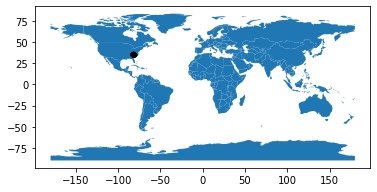

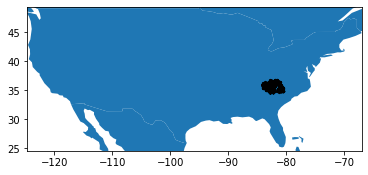

In [47]:
# Get the record coordinates as a data frame
record_coordinates = (pd.read_sql("""SELECT decimalLatitude, decimalLongitude, radius_m 
                                     FROM occurrence_records""", 
                                  con=output_db_conn)
                      .astype({'decimalLongitude': 'float', 'decimalLatitude': 'float'}))

# Make the data frame spatial
gdf = gpd.GeoDataFrame(record_coordinates, geometry=gpd.points_from_xy(records['decimalLongitude'],
                                                   records['decimalLatitude']))
gdf.crs="EPSG:4326"                                            

# Create world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot()
gdf.plot(ax=base, marker='o', color='k', markersize=5)
plt.show()

# Get bounding box for coordinates for use later )))))))))))))))))))))))))))))))))))))))))))))
coordinate_bbox = gdf.geometry.total_bounds

# Plot within USA 
usa_bbox = np.array([-124.725839,   24.498131,  -66.949895,   49.384358])
fig, ax = plt.subplots()
ax.set_xlim(([usa_bbox[0],  usa_bbox[2]]))
ax.set_ylim(([usa_bbox[1],  usa_bbox[3]]))
world.plot(ax=ax)
gdf.plot(ax=ax, marker='o', color='k', markersize=5)
plt.show()

In [ ]:
plot_records = False
if plot_records == True:
    make_records_shapefile()
    '''shp1 = {'file': '{0}{1}_polygons'.format(outDir, summary_name), 'column': None,
            'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'magenta',
            'fillcolor': None, 'marker':'o'}

    # Display occurrence polygons
    map_these=[shp1]

    title="{1} ({0})".format(years, common_name)
    try:
        functions.MapShapefilePolygons(map_these=map_these, title=title)
    except Exception as e:
        print("Unable to map:  " + str(e))'''

### Years represented

In [ ]:
occ_years = [int(x[0]) for x in cursor.execute("SELECT strftime('%Y', eventDate) FROM occurrence_records").fetchall()]
years = filter_set['years_range']
years = years.split(',')
yearsrng = list(range(int(years[0]), int(years[1]), 1))
binsnum = int(years[1]) - int(years[0])
plt.hist(occ_years, bins=binsnum)
plt.ylabel("number of records")
plt.xlabel("year")
plt.xticks(yearsrng, rotation=90)
plt.title("Occurrences per Year")

### Months represented

In [ ]:
occ_months = [int(x[0]) for x in cursor.execute("SELECT strftime('%m', eventDate) FROM occurrence_records").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of records")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

### Distribution of coordinate uncertainty values

In [ ]:
'''occ_cert = [int(x[0]) for x in cursor.execute("SELECT coordinateUncertaintyInMeters FROM occurrence_records").fetchall()]
maxi = np.max(occ_cert)
plt.figure(figsize=(16,4))
plt.hist(occ_cert, bins=50, color="r")
plt.xticks(range(0, maxi, int(maxi/50)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("meters")
plt.title("Coordinate Uncertainty")'''

In [ ]:
'''occ_cert = [int(x[0]) for x in curs_occ.execute("SELECT coordinateUncertaintyInMeters FROM occurrences").fetchall()]
plt.figure(figsize=(16,4))
plt.boxplot(occ_cert, vert=False)
plt.xlabel("meters")
plt.title("Coordinate Uncertainty")'''

In [ ]:
'''rng_max = 2000
occ_cert2 = [x for x in occ_cert if x <= rng_max]
plt.figure(figsize=(12,4))
plt.hist(occ_cert2, bins=30, color="m", align='mid')
plt.xticks(range(0, rng_max + 100, int(rng_max/30.)), rotation=90)
plt.ylabel("number of records")
plt.xlabel("meters")
plt.title("Coordinate Uncertainties Below 2km")'''

### Establishment means reported

In [ ]:
establishment = pd.read_sql(sql="SELECT * FROM attribute_value_counts WHERE attribute = 'establishmentMeans';", con=output_db_conn)
print(establishment[['value', 'acquired', 'removed', 'retained']])

### Identification qualifiers included

In [ ]:
'''quali = curs_occ.execute("SELECT DISTINCT vals FROM unique_values WHERE field = 'IDqualifier' AND step = 'filter';").fetchall()[0]
for q in quali:
    q = q.replace('[', '').strip().replace(']', '').replace("'", "")
    print(q)
'''

### Remarks included

In [ ]:
'''remarks = output_db_conn.execute("SELECT DISTINCT remarks FROM occurrence_records;").fetchall()
if len(remarks) <= 20:
    try:
        for rem in remarks:
            if rem[0][0:1] == ';':
                print(rem[0][2:])
            else:
                print(rem[0])
    except:
        pass
else:
    print("More than 20 remarks, consult the occurrence database.")'''

### Attributes returned for the records from the GBIF request
This count was made before filters were applied

In [ ]:
if use_GBIF == True:
    fields_summary = pd.read_sql("SELECT * FROM gbif_fields_returned", output_db_conn)
    fields_summary.index.name = 'Field'
    pd.set_option('display.max_rows', 250)
    print(fields_summary)

### Attributes returned for the records from the eBird request
This count was made before filters were applied

In [ ]:
if use_eBird == True:
    fields_summary = pd.read_sql("SELECT * FROM ebird_fields_returned", output_db_conn)
    fields_summary.index.name = 'Field'
    pd.set_option('display.max_rows', 250)
    print(fields_summary)

### Citations for records downloaded from GBIF

In [ ]:
'''if get_dwca == True:
    print(cursor.execute("SELECT citations FROM GBIF_download_info").fetchall()[0][0])
else:
    print("Set 'get_dwca' to True to acquire a list of citations")'''

### Rights associated with records downloaded from GBIF

In [ ]:
'''if get_dwca == True:
    print(curs_occ.execute("SELECT rights FROM GBIF_download_info").fetchall()[0][0])
else:
    print("Set 'get_dwca' to True to see the rights")'''

### GBIF download doi

In [ ]:
'''if get_dwca == True:
    doi = curs_occ.execute("SELECT doi FROM GBIF_download_info").fetchall()[0][0]
    print("https://doi.org/" + doi)
else:
    print("Set 'get_dwca' to True to perform a search with a doi assigned")'''

### GBIF Download Key

In [ ]:
'''if get_dwca == True:
    print(curs_occ.execute("SELECT download_key FROM GBIF_download_info").fetchall()[0][0])
else:
    print("Set 'get_dwca' to True to perform a search with a download key assigned")'''

### Runtime

In [ ]:
t2 = datetime.now()
print(t2 - t1)
#!ipython nbconvert 'NEW_TEMPLATE.ipynb' --to=html --no-input --output-dir="T:/Temp/"